<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/GBM(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# ============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================
print("STEP 1: Importing required libraries...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support, log_loss)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")
print("✓ Libraries imported successfully!")


STEP 1: Importing required libraries...
✓ Libraries imported successfully!


In [57]:

# ============================================================================
# STEP 2: DEFINE THE CLASSIFIER CLASS
# ============================================================================
print("\nSTEP 2: Defining the classifier class...")

class GBMProductionClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42):
        """Initialize GBM classifier with parameters"""
        self.model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state,
            verbose=1
        )
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.quantiles = None
        # Initialize tracking variables for loss and accuracy
        self.train_scores = []
        self.val_scores = []
        self.train_losses = []
        self.val_losses = []

    def load_data(self, train_path, validation_path, test_path):
        """Load and prepare datasets"""
        print("\nSTEP 3A: Loading datasets...")
        self.train_df = pd.read_csv(train_path)
        self.validation_df = pd.read_csv(validation_path)
        self.test_df = pd.read_csv(test_path)

        print(f"✓ Train dataset shape: {self.train_df.shape}")
        print(f"✓ Validation dataset shape: {self.validation_df.shape}")
        print(f"✓ Test dataset shape: {self.test_df.shape}")
        return self

    def create_quantile_labels(self):
        """Create quantile-based labels for production levels"""
        print("\nSTEP 4A: Creating quantile-based labels...")

        production_col = 'Production (M.Ton)'
        production_values = self.train_df[production_col]

        self.quantiles = {
            '20%': production_values.quantile(0.2),
            '40%': production_values.quantile(0.4),
            '60%': production_values.quantile(0.6),
            '80%': production_values.quantile(0.8)
        }

        print(f"✓ Quantile thresholds calculated:")
        for q, val in self.quantiles.items():
            print(f"  {q}: {val:.2f}")

        def categorize_production(value):
            if value <= self.quantiles['20%']:
                return 'Very Low'
            elif value <= self.quantiles['40%']:
                return 'Low'
            elif value <= self.quantiles['60%']:
                return 'Medium'
            elif value <= self.quantiles['80%']:
                return 'High'
            else:
                return 'Very High'

        # Apply categorization to all datasets
        self.train_df['Production_Category'] = self.train_df[production_col].apply(categorize_production)
        self.validation_df['Production_Category'] = self.validation_df[production_col].apply(categorize_production)
        self.test_df['Production_Category'] = self.test_df[production_col].apply(categorize_production)

        print("✓ Production category distribution in training data:")
        distribution = self.train_df['Production_Category'].value_counts().sort_index()
        for category, count in distribution.items():
            print(f"  {category}: {count}")

        return self

    def prepare_features(self):
        """Prepare features for modeling"""
        print("\nSTEP 5A: Preparing features...")

        # Select feature columns (exclude target variables)
        feature_cols = [col for col in self.train_df.columns
                       if col not in ['Production (M.Ton)', 'Production_Category']]
        print(f"✓ Selected {len(feature_cols)} feature columns")

        # Prepare feature matrices and target vectors
        self.X_train = self.train_df[feature_cols]
        self.y_train = self.train_df['Production_Category']
        self.X_val = self.validation_df[feature_cols]
        self.y_val = self.validation_df['Production_Category']
        self.X_test = self.test_df[feature_cols]
        self.y_test = self.test_df['Production_Category']

        # Handle missing values
        self.X_train = self.X_train.fillna(self.X_train.mean())
        self.X_val = self.X_val.fillna(self.X_train.mean())
        self.X_test = self.X_test.fillna(self.X_train.mean())

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Encode categorical labels
        self.y_train_encoded = self.label_encoder.fit_transform(self.y_train)
        self.y_val_encoded = self.label_encoder.transform(self.y_val)
        self.y_test_encoded = self.label_encoder.transform(self.y_test)

        print(f"✓ Feature matrix shape: {self.X_train_scaled.shape}")
        print(f"✓ Target classes: {list(self.label_encoder.classes_)}")
        return self

    def train_model(self, n_epochs=100):
        """Train the GBM model with staged predictions"""
        print(f"\nSTEP 6A: Training GBM model for {n_epochs} epochs...")

        self.model.set_params(n_estimators=n_epochs)
        self.model.fit(self.X_train_scaled, self.y_train_encoded)

        print("STEP 6D: Computing staged predictions for training curves...")
        train_staged_pred = list(self.model.staged_predict(self.X_train_scaled))
        val_staged_pred = list(self.model.staged_predict(self.X_val_scaled))
        train_staged_pred_proba = list(self.model.staged_predict_proba(self.X_train_scaled))
        val_staged_pred_proba = list(self.model.staged_predict_proba(self.X_val_scaled))

        # Calculate accuracy and loss for each epoch
        train_scores = []
        val_scores = []
        train_losses = []
        val_losses = []

        for i in range(len(train_staged_pred)):
            train_acc = accuracy_score(self.y_train_encoded, train_staged_pred[i])
            val_acc = accuracy_score(self.y_val_encoded, val_staged_pred[i])
            train_scores.append(train_acc)
            val_scores.append(val_acc)

            train_loss = log_loss(self.y_train_encoded, train_staged_pred_proba[i])
            val_loss = log_loss(self.y_val_encoded, val_staged_pred_proba[i])
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        self.train_scores = train_scores
        self.val_scores = val_scores
        self.train_losses = train_losses
        self.val_losses = val_losses

        print("✓ Training completed!")
        return self

    def evaluate_model(self, X, y, y_encoded, dataset_name):
        """Evaluate model performance"""
        y_pred_encoded = self.model.predict(X)
        y_pred = self.label_encoder.inverse_transform(y_pred_encoded)

        accuracy = accuracy_score(y_encoded, y_pred_encoded)
        precision_macro = precision_score(y_encoded, y_pred_encoded, average='macro')
        precision_weighted = precision_score(y_encoded, y_pred_encoded, average='weighted')
        recall_macro = recall_score(y_encoded, y_pred_encoded, average='macro')
        recall_weighted = recall_score(y_encoded, y_pred_encoded, average='weighted')
        f1_macro = f1_score(y_encoded, y_pred_encoded, average='macro')
        f1_weighted = f1_score(y_encoded, y_pred_encoded, average='weighted')

        results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'y_true': y,
            'y_pred': y_pred,
            'y_true_encoded': y_encoded,
            'y_pred_encoded': y_pred_encoded
        }
        return results

    def print_classification_metrics(self, results, dataset_name):
        """Print classification metrics"""
        print(f"\n{'='*50}")
        print(f"STEP 8A: {dataset_name.upper()} DATASET METRICS")
        print(f"{'='*50}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision (Macro): {results['precision_macro']:.4f}")
        print(f"Precision (Weighted): {results['precision_weighted']:.4f}")
        print(f"Recall (Macro): {results['recall_macro']:.4f}")
        print(f"Recall (Weighted): {results['recall_weighted']:.4f}")
        print(f"F1 Score (Macro): {results['f1_macro']:.4f}")
        print(f"F1 Score (Weighted): {results['f1_weighted']:.4f}")

        print(f"\nSTEP 8B: Detailed Classification Report for {dataset_name}:")
        print(classification_report(results['y_true'], results['y_pred']))

    def plot_confusion_matrix(self, results, dataset_name):
        """Plot confusion matrix"""
        plt.figure(figsize=(6, 4))
        cm = confusion_matrix(results['y_true'], results['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title(f'Confusion Matrix - {dataset_name} Dataset', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=10)
        plt.ylabel('True Labels', fontsize=10)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_training_curves(self):
        """Plot training vs validation accuracy and loss curves"""
        print("\nSTEP 9B: Plotting training curves (Accuracy and Loss)...")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        epochs = range(1, len(self.train_scores) + 1)

        # Plot accuracy curves
        ax1.plot(epochs, self.train_scores, 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, self.val_scores, 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epochs', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)

        # Plot loss curves
        ax2.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax2.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epochs', fontsize=12)
        ax2.set_ylabel('Log Loss', fontsize=12)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print best metrics
        best_val_epoch = np.argmax(self.val_scores) + 1
        best_val_acc = max(self.val_scores)
        best_val_loss_epoch = np.argmin(self.val_losses) + 1
        best_val_loss = min(self.val_losses)

        print(f"✓ Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_epoch}")
        print(f"✓ Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")

    def plot_feature_importance(self, top_n=20):
        """Plot feature importance"""
        print(f"\nSTEP 9C: Plotting top {top_n} feature importance...")

        feature_names = self.X_train.columns
        importance = self.model.feature_importances_

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance - GBM Model', fontsize=16, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

        print(f"✓ Top {top_n} Most Important Features:")
        for i, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

print("✓ Classifier class defined successfully!")


STEP 2: Defining the classifier class...
✓ Classifier class defined successfully!


In [58]:
# ============================================================================
# STEP 3: INITIALIZE THE CLASSIFIER
# ============================================================================
print("\nSTEP 3: Initializing the classifier...")
gbm_classifier = GBMProductionClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
print("✓ Classifier initialized successfully!")


STEP 3: Initializing the classifier...
✓ Classifier initialized successfully!


In [59]:


# ============================================================================
# STEP 4: DEFINE FILE PATHS (UPDATE THESE WITH YOUR ACTUAL PATHS)
# ============================================================================
print("\nSTEP 4: Setting up file paths...")
train_path = '/content/drive/MyDrive/UpdatedDataset/train.csv'
validation_path = '/content/drive/MyDrive/UpdatedDataset/validation.csv'
test_path = '/content/drive/MyDrive/UpdatedDataset/test.csv'

print(f"✓ Train path: {train_path}")
print(f"✓ Validation path: {validation_path}")
print(f"✓ Test path: {test_path}")



STEP 4: Setting up file paths...
✓ Train path: /content/drive/MyDrive/UpdatedDataset/train.csv
✓ Validation path: /content/drive/MyDrive/UpdatedDataset/validation.csv
✓ Test path: /content/drive/MyDrive/UpdatedDataset/test.csv


In [60]:

# ============================================================================
# STEP 5: LOAD DATA
# ============================================================================
gbm_classifier.load_data(train_path, validation_path, test_path)


STEP 3A: Loading datasets...
✓ Train dataset shape: (3942, 84)
✓ Validation dataset shape: (845, 84)
✓ Test dataset shape: (845, 84)


In [61]:
# ============================================================================
# STEP 6: CREATE QUANTILE LABELS
# ============================================================================
gbm_classifier.create_quantile_labels()



STEP 4A: Creating quantile-based labels...
✓ Quantile thresholds calculated:
  20%: 578.00
  40%: 1463.00
  60%: 3119.52
  80%: 6540.92
✓ Production category distribution in training data:
  High: 788
  Low: 786
  Medium: 786
  Very High: 789
  Very Low: 793


In [62]:
# ============================================================================
# STEP 7: PREPARE FEATURES
# ============================================================================
gbm_classifier.prepare_features()



STEP 5A: Preparing features...
✓ Selected 83 feature columns
✓ Feature matrix shape: (3942, 83)
✓ Target classes: ['High', 'Low', 'Medium', 'Very High', 'Very Low']


In [63]:
# ============================================================================
# STEP 8: TRAIN MODEL
# ============================================================================
gbm_classifier.train_model(n_epochs=100)


STEP 6A: Training GBM model for 100 epochs...
      Iter       Train Loss   Remaining Time 
         1           1.3799           16.99s
         2           1.2139           17.30s
         3           1.0850           16.93s
         4           0.9832           16.54s
         5           0.8978           16.26s
         6           0.8266           16.02s
         7           0.7652           15.85s
         8           0.7131           15.92s
         9           0.6667           15.60s
        10           0.6266           15.34s
        20           0.4016           13.61s
        30           0.3006           11.65s
        40           0.2437            9.80s
        50           0.2015            8.08s
        60           0.1715            6.47s
        70           0.1448            5.13s
        80           0.1246            3.51s
        90           0.1069            1.73s
       100           0.0935            0.00s
STEP 6D: Computing staged predictions for training c

In [64]:

# ============================================================================
# STEP 9: EVALUATE MODEL
# ============================================================================
print("\nSTEP 9: Evaluating model performance...")

# Validation results
val_results = gbm_classifier.evaluate_model(
    gbm_classifier.X_val_scaled,
    gbm_classifier.y_val,
    gbm_classifier.y_val_encoded,
    'Validation'
)

# Test results
test_results = gbm_classifier.evaluate_model(
    gbm_classifier.X_test_scaled,
    gbm_classifier.y_test,
    gbm_classifier.y_test_encoded,
    'Test'
)

print("✓ Model evaluation completed!")



STEP 9: Evaluating model performance...
✓ Model evaluation completed!


In [65]:
# ============================================================================
# STEP 10: PRINT CLASSIFICATION METRICS
# ============================================================================
gbm_classifier.print_classification_metrics(val_results, 'Validation')
gbm_classifier.print_classification_metrics(test_results, 'Test')



STEP 8A: VALIDATION DATASET METRICS
Accuracy: 0.8686
Precision (Macro): 0.8662
Precision (Weighted): 0.8714
Recall (Macro): 0.8693
Recall (Weighted): 0.8686
F1 Score (Macro): 0.8666
F1 Score (Weighted): 0.8689

STEP 8B: Detailed Classification Report for Validation:
              precision    recall  f1-score   support

        High       0.78      0.83      0.81       160
         Low       0.79      0.87      0.83       140
      Medium       0.86      0.77      0.81       191
   Very High       0.95      0.92      0.93       169
    Very Low       0.95      0.95      0.95       185

    accuracy                           0.87       845
   macro avg       0.87      0.87      0.87       845
weighted avg       0.87      0.87      0.87       845


STEP 8A: TEST DATASET METRICS
Accuracy: 0.8651
Precision (Macro): 0.8669
Precision (Weighted): 0.8683
Recall (Macro): 0.8642
Recall (Weighted): 0.8651
F1 Score (Macro): 0.8649
F1 Score (Weighted): 0.8660

STEP 8B: Detailed Classification Repo


STEP 9B: Plotting training curves (Accuracy and Loss)...


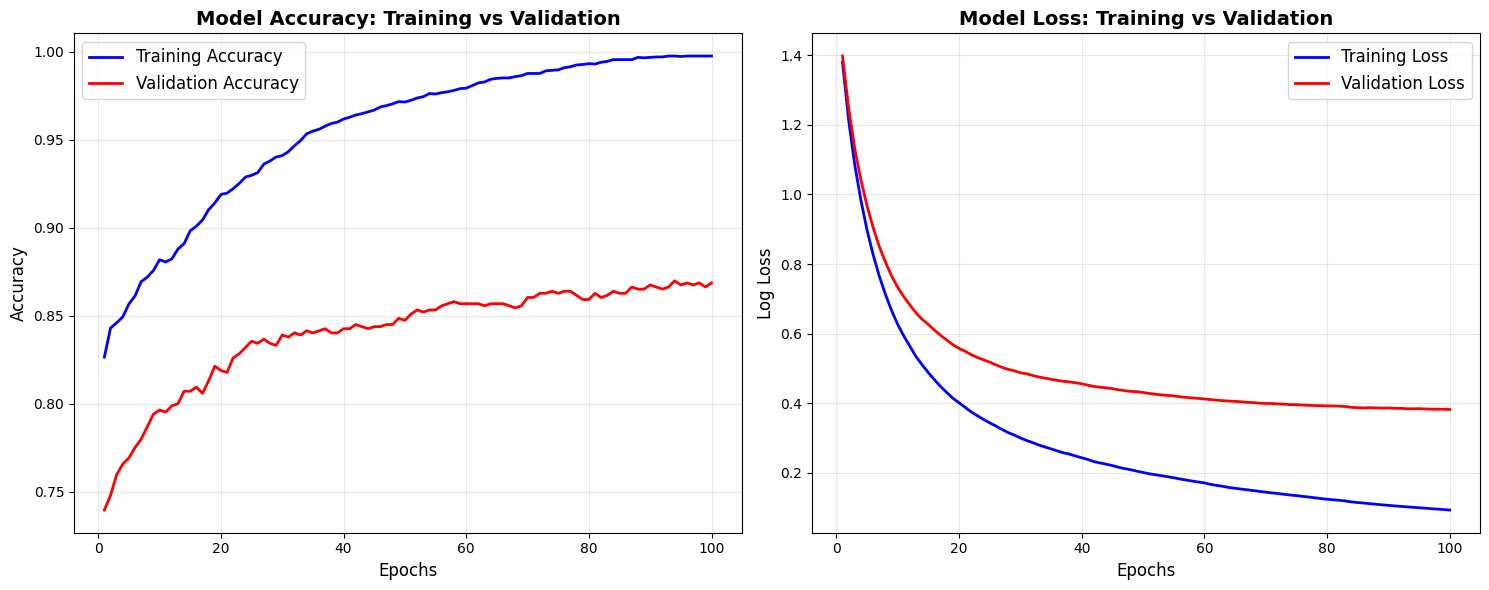

✓ Best validation accuracy: 0.8698 at epoch 94
✓ Best validation loss: 0.3822 at epoch 100


In [66]:
# ============================================================================
# STEP 11: PLOT TRAINING CURVES (ACCURACY AND LOSS)
# ============================================================================
gbm_classifier.plot_training_curves()


STEP 12: Plotting confusion matrices...


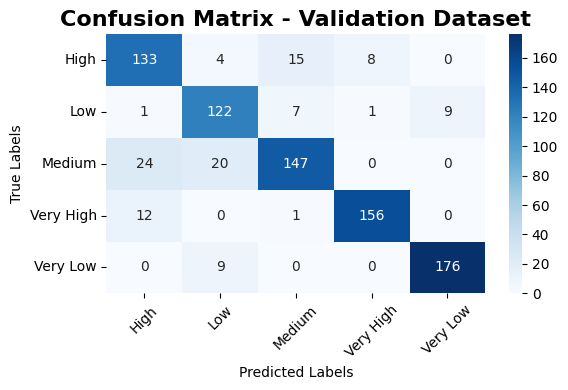

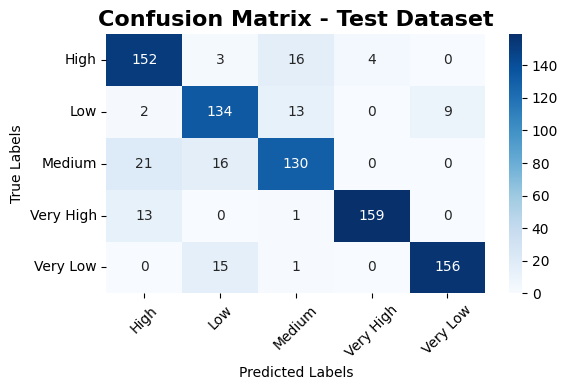

In [67]:

# ============================================================================
# STEP 12: PLOT CONFUSION MATRICES
# ============================================================================
print("\nSTEP 12: Plotting confusion matrices...")
gbm_classifier.plot_confusion_matrix(val_results, 'Validation')
gbm_classifier.plot_confusion_matrix(test_results, 'Test')



STEP 9C: Plotting top 20 feature importance...


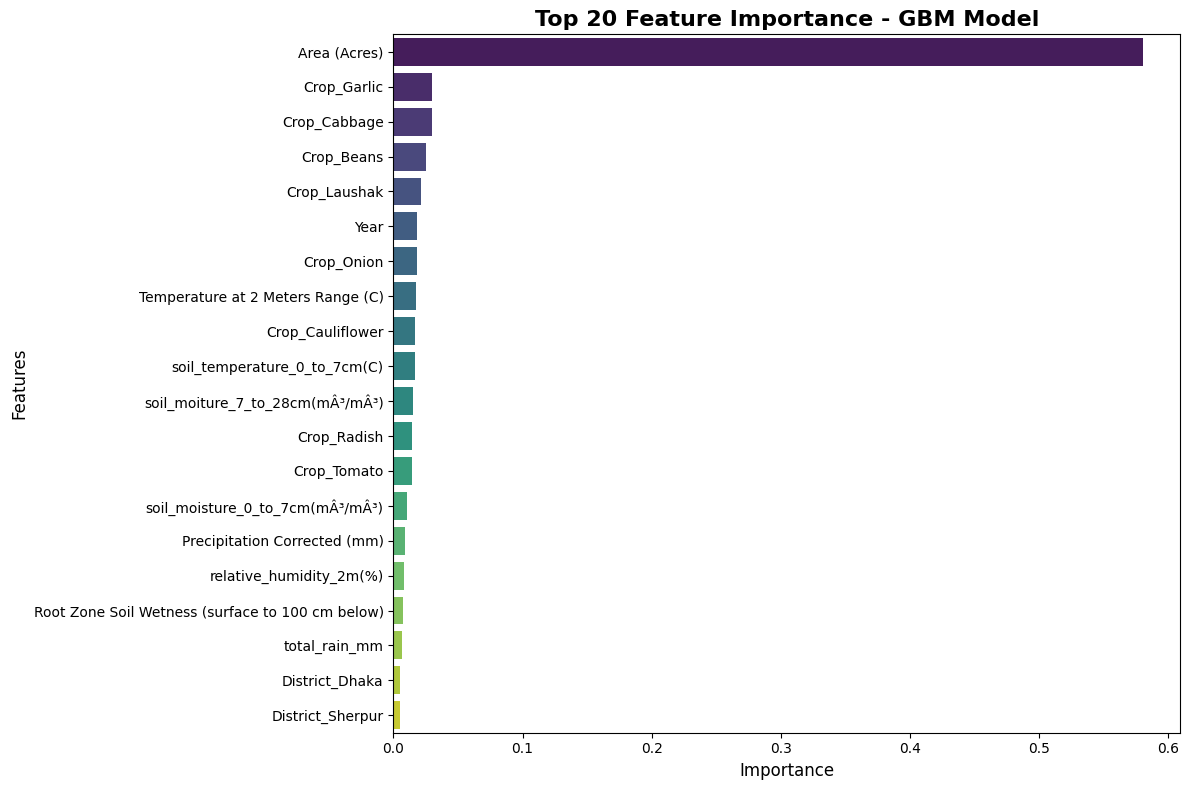

✓ Top 20 Most Important Features:
  Area (Acres): 0.5799
  Crop_Garlic: 0.0301
  Crop_Cabbage: 0.0296
  Crop_Beans: 0.0254
  Crop_Laushak: 0.0217
  Year: 0.0180
  Crop_Onion: 0.0179
  Temperature at 2 Meters Range (C): 0.0172
  Crop_Cauliflower: 0.0166
  soil_temperature_0_to_7cm(C): 0.0164
  soil_moiture_7_to_28cm(mÂ³/mÂ³): 0.0155
  Crop_Radish: 0.0147
  Crop_Tomato: 0.0145
  soil_moisture_0_to_7cm(mÂ³/mÂ³): 0.0102
  Precipitation Corrected (mm): 0.0088
  relative_humidity_2m(%): 0.0081
  Root Zone Soil Wetness (surface to 100 cm below): 0.0073
  total_rain_mm: 0.0068
  District_Dhaka: 0.0054
  District_Sherpur: 0.0051


In [68]:
# ============================================================================
# STEP 13: PLOT FEATURE IMPORTANCE
# ============================================================================
gbm_classifier.plot_feature_importance()



STEP 14: Comparing validation vs test performance...


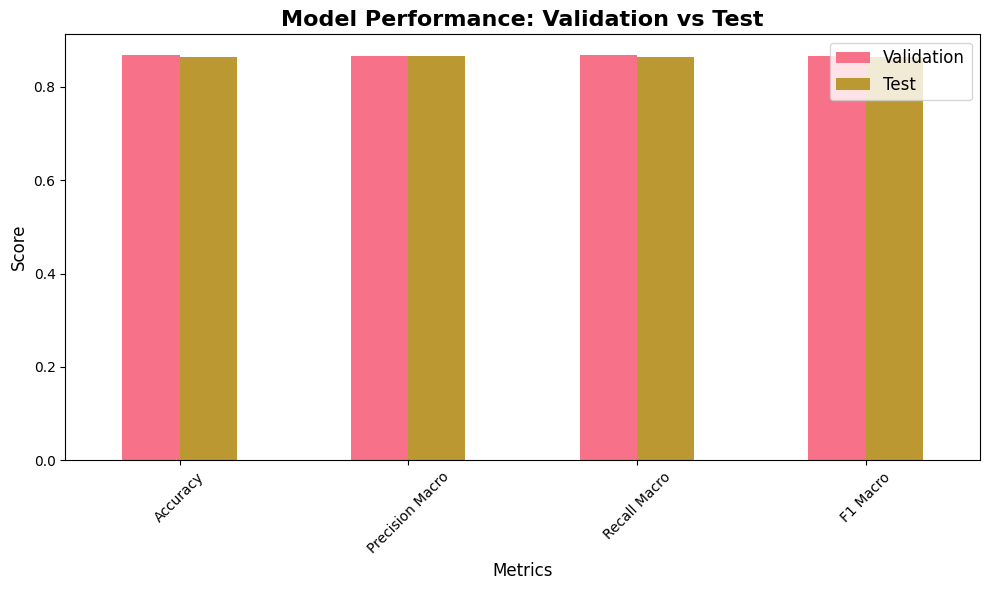

In [69]:

# ============================================================================
# STEP 14: PERFORMANCE COMPARISON
# ============================================================================
print("\nSTEP 14: Comparing validation vs test performance...")

def compare_models_performance(val_results, test_results):
    """Compare validation vs test performance"""
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    comparison_df = pd.DataFrame({
        'Validation': [val_results[metric] for metric in metrics],
        'Test': [test_results[metric] for metric in metrics]
    }, index=[metric.replace('_', ' ').title() for metric in metrics])

    comparison_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance: Validation vs Test', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison_df

comparison_df = compare_models_performance(val_results, test_results)

In [70]:
# ============================================================================
# STEP 16: FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("FINAL SUMMARY OF RESULTS")
print("="*60)
print(f"✓ Validation Macro F1 Score: {val_results['f1_macro']:.4f}")
print(f"✓ Test Macro F1 Score: {test_results['f1_macro']:.4f}")
print(f"✓ Validation Accuracy: {val_results['accuracy']:.4f}")
print(f"✓ Test Accuracy: {test_results['accuracy']:.4f}")

print("\n" + "="*60)
print("✓ ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*60)


FINAL SUMMARY OF RESULTS
✓ Validation Macro F1 Score: 0.8666
✓ Test Macro F1 Score: 0.8649
✓ Validation Accuracy: 0.8686
✓ Test Accuracy: 0.8651

✓ ALL STEPS COMPLETED SUCCESSFULLY!
